This analysis aims to predict loan default risk based on borrower characteristics and loan details. The dataset contains information about borrowers and their loans, including whether they defaulted.

import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

uploading data set in google colab using the following functions


In [ ]:
df = pd.read_csv('credit_risk_dataset.csv')

In [ ]:
# Data Exploration
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


1.Handle missing values - we'll impute numerical with median and categorical with mode
2.For loan_int_rate, which has missing values, we'll impute with median

In [ ]:
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

/tmp/ipython-input-31-364895585.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)


handling missing values by replacing with their median value

In [ ]:
# Handle person_emp_length missing values
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

/tmp/ipython-input-32-1805408415.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)


in ages there are some unrealistics values of about age of person so we are removing that column

In [ ]:
df = df[df['person_age'] < 100]  # Remove unrealistic ages

Now we are performing feature engineering by creating a new column called debt_to_income where we can analyse persons load towards income .

In [ ]:
df['debt_to_income'] = df['loan_amnt'] / df['person_income']

Now separate features and targets and then train the test set data

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Now defining preproocessing steps

In [ ]:
numerical_features = ['person_age', 'person_income', 'person_emp_length',
                     'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                     'cb_person_cred_hist_length', 'debt_to_income']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade',
                       'cb_person_default_on_file']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

Creating model pipelines

In [ ]:
model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=42, class_weight='balanced',n_estimators=100))])

Train the model using train test split

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

now printing the confusion matrix as it is the best best performance evalute in case of Random forest algorithms used for making the model

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5094
           1       0.97      0.71      0.82      1422

    accuracy                           0.93      6516
   macro avg       0.95      0.85      0.89      6516
weighted avg       0.94      0.93      0.93      6516


Confusion Matrix:
[[5066   28]
 [ 414 1008]]

ROC AUC Score: 0.9313917341324865


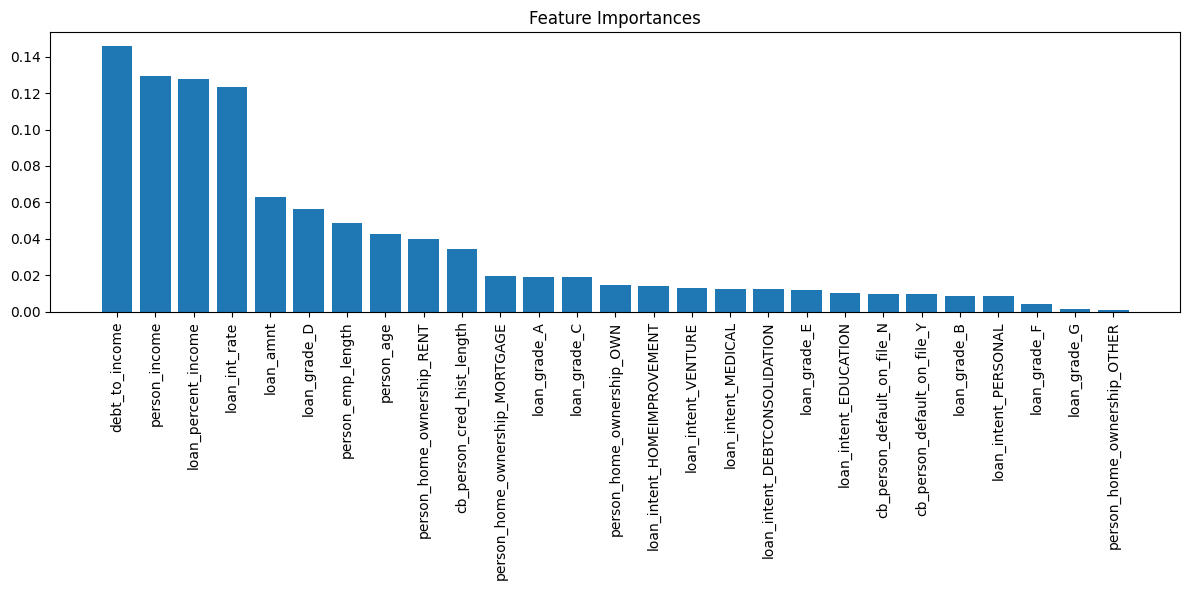

In [ ]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Plot feature importances
# feature names after one-hot encoding
feature_names = numerical_features
ohe_categories = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_
for i, cat in enumerate(categorical_features):
    for value in ohe_categories[i]:
        feature_names.append(f"{cat}_{value}")

importances = model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Now here is the performance matrix of accuracy printed below

In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nKey Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")


Key Metrics:
Accuracy: 0.9322
Precision: 0.9730
Recall: 0.7089
F1-Score: 0.8202
ROC-AUC: 0.9314
Log Loss: 0.2431


Conclusion - Our model Random Forest to predict loan defaults, which is well-suited for credit risk analysis due to its ability to:

 Handle imbalanced data (common in defaults vs non-defaults).
 Process mixed data types (numerical + categorical features).
 Reduce overfitting (via ensemble learning).
 Provide interpretable feature importance (key drivers of risk).